<a href="https://colab.research.google.com/github/yukinaga/image_classification/blob/main/section_2/02_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNNの実装
PyTorchを使って、畳み込みニューラルネットワーク（CNN）を実装します。  
CNN自体はCNNの層を追加するのみで実装可能なのですが、今回はデータ拡張とドロップアウトの実装も行います。  
学習に時間がかかるので、「編集」→「ノートブックの設定」の「ハードウェアアクセラレーター」で「GPU」を選択しましょう。

In [4]:
# GPUが使用可能か確認
import torch

print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

True
NVIDIA GeForce RTX 3060


## データの前処理
ここからCNNを実装します。  
データ拡張として、回転とリサイズ、および左右反転を行います。  
また、学習が効率的になるように入力の平均値を0、標準偏差を1にします（標準化）。  
DataLoaderは、訓練データ、テストデータそれぞれで設定します。

In [5]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

affine = transforms.RandomAffine([-30, 30], scale=(0.8, 1.2))  # 回転とリサイズ
flip = transforms.RandomHorizontalFlip(p=0.5)  # 左右反転
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # 平均値を0、標準偏差を1に
to_tensor = transforms.ToTensor()

transform_train = transforms.Compose([affine, flip, to_tensor, normalize])
transform_test = transforms.Compose([to_tensor, normalize])
cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform_test)

# DataLoaderの設定
batch_size = 64
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## モデルの構築
`nn.Module`モジュールを継承したクラスとして、CNNのモデルを構築します。  
今回は、全結合層にニューロンをランダムに削除する「ドロップアウト」を導入します。  
ドロップアウトを導入することで、未知のデータに対してより頑強になるようにモデルを訓練することができます。    

In [6]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 畳み込み層:(入力チャンネル数, フィルタ数, フィルタサイズ)
        self.relu = nn.ReLU()  # ReLU
        self.pool = nn.MaxPool2d(2, 2)  # プーリング層:（領域のサイズ, 領域の間隔）
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 256)  # 全結合層
        self.dropout = nn.Dropout(p=0.5)  # ドロップアウト:(p=ドロップアウト率)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16*5*5)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = Net()
net.cuda()  # GPU対応
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


各層で、画像のサイズ(チャンネル数, 画像高さ, 画像幅)
は以下の通りに変化します。  
  
入力画像: (3, 32, 32)  
↓  
nn.Conv2d(3, 6, 5): (6, 28, 28)  
↓  
nn.MaxPool2d(2, 2): (6, 14, 14)  
↓  
nn.Conv2d(6, 16, 5): (16, 10, 10)  
↓  
nn.MaxPool2d(2, 2): (16, 5, 5)  
  
画像の高さおよび幅は、以下の式を使って計算しました。  

$$O_h=\frac{I_h-F_h+2D}{S}+1$$
$$O_w=\frac{I_w-F_w+2D}{S}+1$$

$O_h$、$O_w$: 出力画像の高さ、幅  
$I_h$、$I_w$: 入力画像の高さ、幅  
$F_h$、$F_w$: フィルタの高さ、幅  
$D$: パディング  
$S$: ストライド  
  
今回、全ての畳み込み層でパディングは0、ストライドは1となっています。  

## 学習
モデルを訓練します。  
DataLoaderを使い、ミニバッチを取り出して訓練および評価を行います。  

In [7]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
for i in range(20):  # 20エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    loss_test = 0
    for j, (x, t) in enumerate(test_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()
        y = net(x)
        loss = loss_fnc(y, t)
        loss_test += loss.item()
    loss_test /= j+1
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 1.845341488375993 Loss_Test: 1.5769372563453237
Epoch: 1 Loss_Train: 1.6152235002773803 Loss_Test: 1.4473436228029288
Epoch: 2 Loss_Train: 1.5531003536165828 Loss_Test: 1.3923498513592276
Epoch: 3 Loss_Train: 1.5112205539518 Loss_Test: 1.3568122417304167
Epoch: 4 Loss_Train: 1.4711032000649007 Loss_Test: 1.3094605723763728
Epoch: 5 Loss_Train: 1.4471094224154186 Loss_Test: 1.2967069650151928
Epoch: 6 Loss_Train: 1.4289675751305602 Loss_Test: 1.3386516153432761
Epoch: 7 Loss_Train: 1.4131237425462668 Loss_Test: 1.2536944895033624
Epoch: 8 Loss_Train: 1.395959664946017 Loss_Test: 1.2568957505712084
Epoch: 9 Loss_Train: 1.3850031922692838 Loss_Test: 1.2345859955070884
Epoch: 10 Loss_Train: 1.3804773795787635 Loss_Test: 1.2453955279034414
Epoch: 11 Loss_Train: 1.3685294635155623 Loss_Test: 1.1958071988099699
Epoch: 12 Loss_Train: 1.3569019435311827 Loss_Test: 1.215891254935295
Epoch: 13 Loss_Train: 1.3411371612640293 Loss_Test: 1.1868920257896374
Epoch: 14 Loss_Train: 

## 誤差の推移
訓練データ、テストデータで誤差の推移をグラフ表示します。  

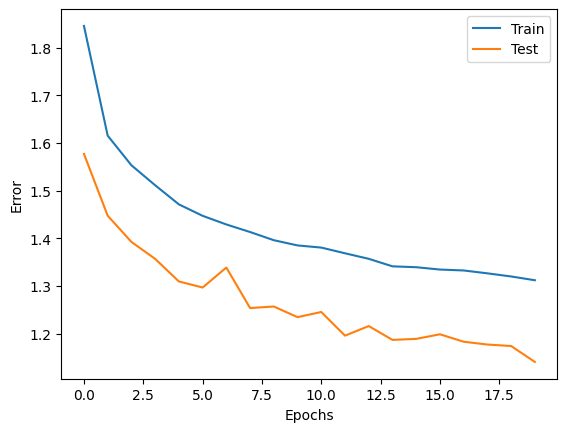

In [8]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## 正解率
モデルの性能を把握するため、テストデータ使い正解率を測定します。  

In [9]:
correct = 0
total = 0
net.eval()  # 評価モード
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()  # GPU対応
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 59.77%


## 訓練済みのモデルを使った予測
訓練済みのモデルを使ってみましょう。  
画像を入力し、モデルが機能していることを確かめます。

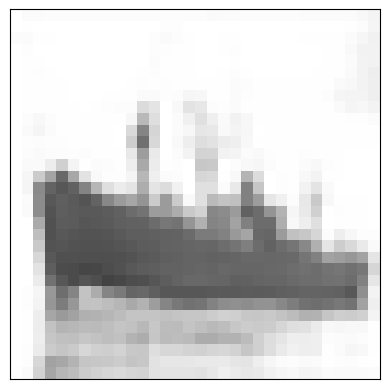

正解: ship 予測結果: ship


In [20]:
cifar10_classes = ["airplane", "automobile", "bird",
                   "cat", "deer", "dog", "frog",
                   "horse", "ship", "truck"]

cifar10_loader = DataLoader(cifar10_test, batch_size=1, shuffle=True)
dataiter = iter(cifar10_loader)
images, labels = next(dataiter)  # サンプルを1つだけ取り出す

plt.imshow(images[0].permute(1, 2, 0))  # 一番後の次元をチャンネルに
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に
plt.show()

net.eval()  # 評価モード
x, t = images.cuda(), labels.cuda()  # GPU対応
y = net(x)
print("正解:", cifar10_classes[labels[0]],
      "予測結果:", cifar10_classes[y.argmax().item()])